In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.compose import make_column_selector
from sklearn.preprocessing import KBinsDiscretizer, LabelEncoder, OneHotEncoder, OrdinalEncoder, RobustScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [44]:
X_train = pd.read_csv("X_train_tran.csv")
y_train = pd.read_csv("y_train_tran.csv")
X_val = pd.read_csv("X_val_tran.csv")
y_val = pd.read_csv("y_val_tran.csv")
myColumns = X_train.columns

In [45]:
df = pd.read_csv("Customer-Churn-Records.csv")

df = df.drop(columns=['RowNumber','CustomerId'])
df = df.drop(columns=['Complain'])
df = df.rename(columns={'Card Type': 'CardType'})
df = df.rename(columns={'Point Earned': 'PointsEarned'})
df = df.rename(columns={'Geography': 'Country'})
df = df.rename(columns={'Satisfaction Score': 'SatisfactionScore'})
# save original columns
myColumns_df = df.columns

In [46]:
X_train.head()

,Tenure,NumOfProducts,HasCrCard,IsActiveMember,SatisfactionScore,CreditScoreOrd,AgeOrd,TaxBracket,BalanceOrd,PointsEarnedQuant,CardTypeOrd,SurnameOrd,CountryOrd,CountryHappy,GenderBinary
0,2,2,1,0,2,3,1,4,0,1.0,1.0,0.0,1,6.48,0
1,1,1,1,1,1,4,1,3,1,2.0,2.0,0.0,2,6.69,0
2,2,1,0,1,1,4,4,4,3,2.0,0.0,0.0,2,6.69,0
3,4,1,1,0,1,2,1,1,2,0.0,2.0,2.0,3,7.03,1
4,8,2,0,1,3,3,3,3,0,2.0,0.0,0.0,2,6.69,1


<font color='skyBlue'> 
We start by looking at how an un-optimized RandomForest classifier rates the feature importance

I compare the feature importance between the transformed dataset and the original churn dataset. To be able to compare i use a pretty standard pipeline with onehot, ordinal, and robustscaler.
</font>

In [47]:
y_train = np.ravel(y_train)

# Adjusts weights so that the undersampled class get higher weight
class_weights = dict(zip(np.unique(y_train), [len(y_train) / (len(np.unique(y_train)) * np.bincount(y_train)[i]) for i in np.unique(y_train)]))
class_weights

# Create a Random Forest classifier
rf_model = RandomForestClassifier(class_weight=class_weights)

# Train the Random Forest model
rf_model.fit(X_train, y_train)

# Get feature importances
feature_importances = rf_model.feature_importances_

# Create a DataFrame to store feature importances
importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances})

# Sort the DataFrame by importance (descending order)
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Display the features in order of importance
n = len(X_train.columns)  # Number of top features to display
top_features = importance_df.head(n)
print(f"Top {n} important features:")
print(top_features)
 
 # Make predictions on the test set
y_pred = rf_model.predict(X_val)

# Generate the classification report
report = classification_report(y_val, y_pred)
print("Classification Report:")
print(report)
#* NuOfProducts is more important than was shown in the correlation map!
#* Tenure is also more important now than was shown on the correlation map.
#* Surprised gender is not used to a more significant degree
#* Surname encoding seems to not have worked
#* Wonder why balance and income are not very close to each other
#* Country could most likely be used better

Top 15 important features:
              Feature  Importance
6              AgeOrd    0.160690
1       NumOfProducts    0.130917
0              Tenure    0.110911
8          BalanceOrd    0.084066
9   PointsEarnedQuant    0.077434
4   SatisfactionScore    0.077018
5      CreditScoreOrd    0.072771
10        CardTypeOrd    0.064858
7          TaxBracket    0.056582
3      IsActiveMember    0.041064
12         CountryOrd    0.031857
13       CountryHappy    0.029489
2           HasCrCard    0.027185
14       GenderBinary    0.026426
11         SurnameOrd    0.008732
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.97      0.91       796
           1       0.75      0.38      0.50       204

    accuracy                           0.85      1000
   macro avg       0.81      0.67      0.71      1000
weighted avg       0.84      0.85      0.83      1000



<font color='lightblue'> 
I want to see if the original features differ in feature importance
</font>

In [48]:
X = df.drop(['Exited','Surname'], axis=1) # I drop Surname since we have not encoded it
y = df['Exited']
# yy = np.ravel(y)
X_trainDF, X_valDF, y_trainDF, y_valDF = train_test_split(X, y, test_size=0.2, random_state=40)


# Define the categorical features for one-hot encoding
categorical_features = ['Country', 'Gender', 'HasCrCard', 'IsActiveMember','CardType']

# Define the ordinal features for ordinal encoding
ordinal_features = ['Tenure', 'NumOfProducts', 'SatisfactionScore']

# Define the continuous features for scaling
continuous_features = ['CreditScore', 'Age', 'Balance', 'PointsEarned', 'EstimatedSalary']

# Define the preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(), categorical_features),
        ('ordinal', OrdinalEncoder(), ordinal_features),
        ('scaler', RobustScaler(), continuous_features) # For potential outliers
    ])

# Adjusts weights so that the undersampled class get higher weight
class_weights = dict(zip(np.unique(y_trainDF), [len(y_trainDF) / (len(np.unique(y_trainDF)) * np.bincount(y_trainDF)[i]) for i in np.unique(y_trainDF)]))
class_weights

# Define the Random Forest classifier
classifier = RandomForestClassifier(class_weight=class_weights)

# Create the pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', classifier)
])

# Fit the pipeline to the training data
pipeline.fit(X_trainDF, y_trainDF)

# Get feature importances
feature_importances = pipeline.named_steps['classifier'].feature_importances_

# Create a DataFrame to store feature importances
importance_df = pd.DataFrame({'Feature': pipeline.named_steps['preprocessor'].get_feature_names_out(), 'Importance': feature_importances})

# Sort the DataFrame by importance (descending order)
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Print feature importances
print("Feature Importances:")
for feature, importance in zip(importance_df['Feature'], importance_df['Importance']):
    print(feature, importance)

#* We can see that my transformations did make some difference but its a bit hard to interpret when you onehot encode. Age and NumOfProducts seems to still be of similar importance. TaxBracket is valued as more important here as well as country. 'separating' countries with onehot might help the model. Perhaps the feature differences will play a bigger role when it comes to hyperparameter tuning

Feature Importances:
scaler__Age 0.22273821967961094
ordinal__NumOfProducts 0.10621005306810602
scaler__Balance 0.1036001719553055
scaler__EstimatedSalary 0.09860774007392753
scaler__PointsEarned 0.09531039622817061
scaler__CreditScore 0.09514198269429261
ordinal__Tenure 0.06224433471702473
ordinal__SatisfactionScore 0.04233934260605584
onehot__Country_Germany 0.023386077385788254
onehot__IsActiveMember_1 0.020593949524294497
onehot__IsActiveMember_0 0.01824997055980271
onehot__CardType_DIAMOND 0.011971932722827695
onehot__CardType_SILVER 0.011903862161809588
onehot__Country_France 0.011899557599188154
onehot__CardType_PLATINUM 0.011763898442634318
onehot__CardType_GOLD 0.011551945205263855
onehot__HasCrCard_0 0.01105289021321021
onehot__HasCrCard_1 0.010924492870532852
onehot__Gender_Female 0.01082879043843794
onehot__Gender_Male 0.010327077054378131
onehot__Country_Spain 0.00935331479933804


<font color='skyBlue'> 
Lets look at mutual information for both the transformed and original data
</font>

In [49]:
from sklearn.feature_selection import mutual_info_classif
# determine the mutual information
X_train_num = X_train[['Tenure', 'NumOfProducts','SatisfactionScore', 'PointsEarnedQuant','AgeOrd','TaxBracket','BalanceOrd',]]
mutual_info = mutual_info_classif(X_train_num, y_train)
mutual_info

array([0.        , 0.07003827, 0.0057565 , 0.        , 0.0602434 ,
       0.00121024, 0.00931083])

In [50]:
mutual_info = pd.Series(mutual_info)
mutual_info.index = X_train_num.columns
mutual_info.sort_values(ascending=False)

NumOfProducts        0.070038
AgeOrd               0.060243
BalanceOrd           0.009311
SatisfactionScore    0.005756
TaxBracket           0.001210
Tenure               0.000000
PointsEarnedQuant    0.000000
dtype: float64

<Axes: >

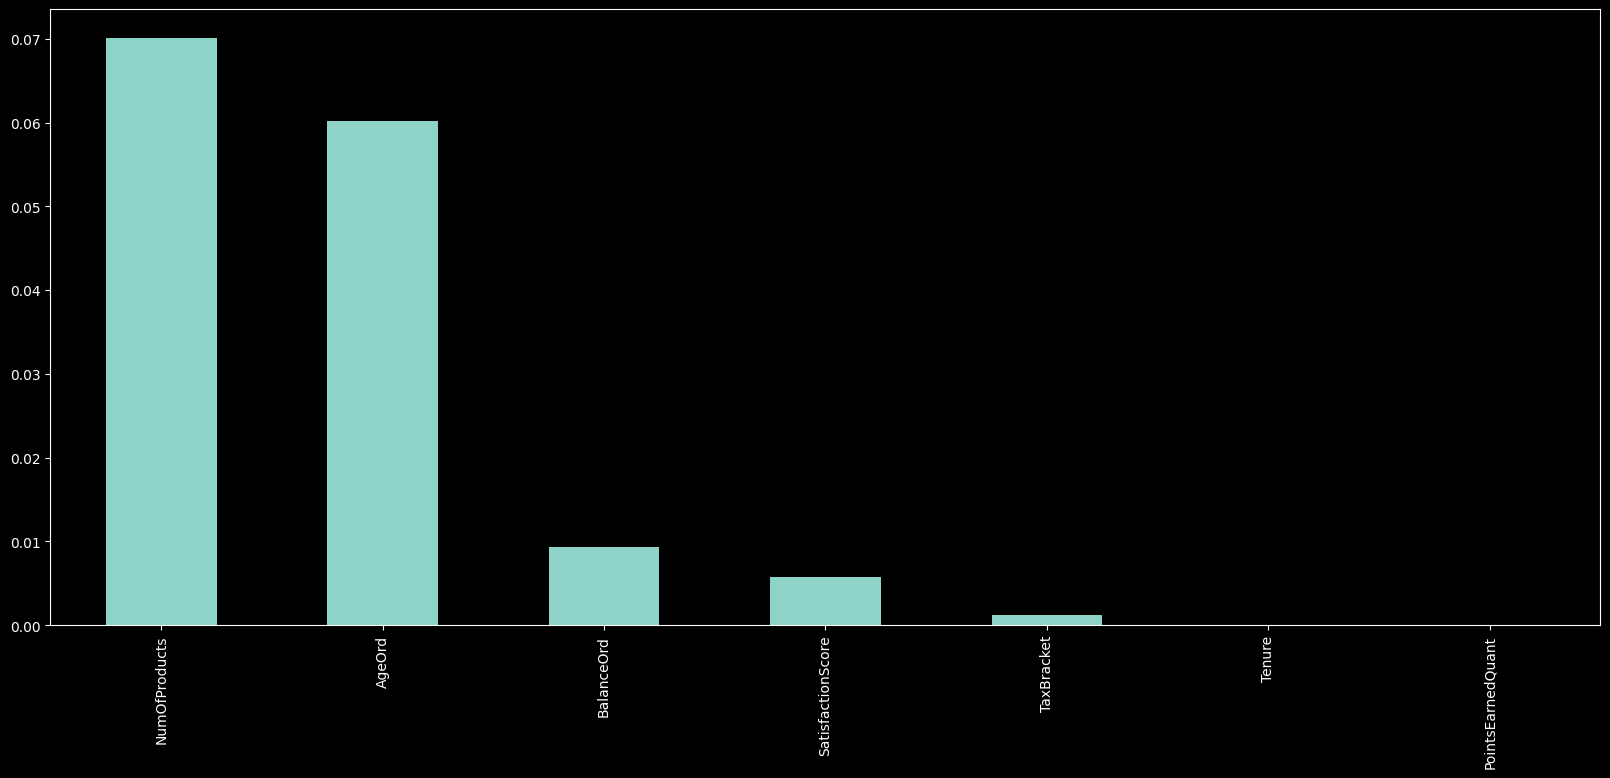

In [51]:
#let's plot the ordered mutual_info values per feature
mutual_info.sort_values(ascending=False).plot.bar(figsize=(20, 8))

#* After Balance, the features have very low scores

In [52]:
from sklearn.feature_selection import mutual_info_classif
# determine the mutual information
X_trainDF_num = X_trainDF[['Age', 'Tenure','Balance', 'NumOfProducts','EstimatedSalary','SatisfactionScore','PointsEarned',]]
mutual_info222 = mutual_info_classif(X_trainDF_num, y_trainDF)
mutual_info222

array([0.0652969 , 0.00829133, 0.01151676, 0.0730117 , 0.00592067,
       0.        , 0.00504819])

In [53]:
mutual_info222 = pd.Series(mutual_info222)
mutual_info222.index = X_trainDF_num.columns
mutual_info222.sort_values(ascending=False)

NumOfProducts        0.073012
Age                  0.065297
Balance              0.011517
Tenure               0.008291
EstimatedSalary      0.005921
PointsEarned         0.005048
SatisfactionScore    0.000000
dtype: float64

<Axes: >

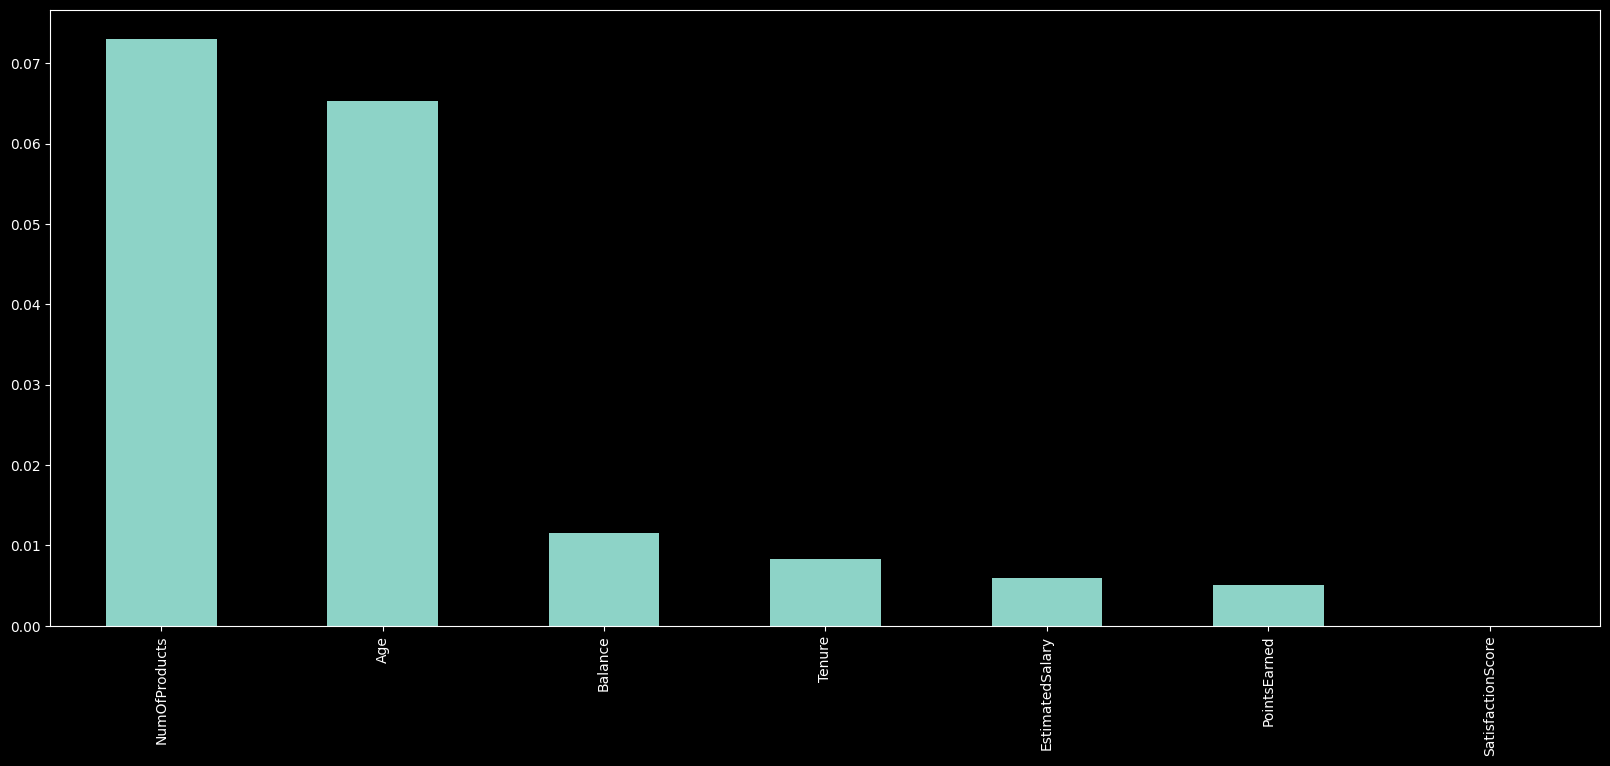

In [54]:
#let's plot the ordered mutual_info values per feature
mutual_info222.sort_values(ascending=False).plot.bar(figsize=(20, 8))

#* Balance gets a lower score but EstimatedSalary, and Tenure get a higher score. Could this be intepered as it being not worth transform EstimatedSalary
#* tbh i have a bit of hard time understanding how estimatedSalary can have rather high mutual info but still score low as a feature of importance for the randomForrest.

<font color='skyBlue'> 
Let us also look at the categorical features in a similar way using chi-square test.
We dont need to test both transformed and original since they are in the same format.
</font>

In [55]:
from sklearn.feature_selection import chi2
# * We will consider binary features as categorical
# * Surname is not really categorical now after it has been encoded
X_train_cat = X_train[['GenderBinary', 'CountryOrd','SurnameOrd','HasCrCard','IsActiveMember']]
f_p_values=chi2(X_train_cat ,y_train)

In [56]:
p_values=pd.Series(f_p_values[1])
p_values.index=X_train_cat.columns
p_values.sort_values(ascending=True)
#* HasCrCard and Surname are above the standard 0.05, so we can view them as not significant

IsActiveMember    3.750575e-20
GenderBinary      2.002341e-12
CountryOrd        1.054061e-10
HasCrCard         4.240394e-01
SurnameOrd        7.075608e-01
dtype: float64

<font color='skyBlue'> 
Let us take a look if classification remains mostly the same if we use PCA to reduce the features.
</font>

In [57]:


# Perform PCA with the desired percentage of variance
pca = PCA(0.95)  # 95% of variance
X_pca = pca.fit_transform(X_train)

# Transform the validation data using the preprocessor
X_val_pca = pca.transform(X_val)

# Get the actual number of components that explain the desired variance
n_components = pca.n_components_

# Print the number of components and the explained variance ratio
print("Number of Components:", n_components)
print("Explained Variance Ratio:", pca.explained_variance_ratio_)

#* we reduce the features from 15 to 10. Which could be really advantageous if we had so much data so that it took a long time to train the model
#* This does tell us that even though there is not much correlation and information in the features according to the tests, the model can still find use for them.


Number of Components: 10
Explained Variance Ratio: [0.37360462 0.10230878 0.09119447 0.08921701 0.08714033 0.0556375
 0.05078668 0.04847998 0.03635011 0.02050438]


In [58]:
# Create a Random Forest classifier
rf_model = RandomForestClassifier()

# Train the Random Forest model
rf_model.fit(X_pca, y_train)

# Make predictions on the test set
y_pred = rf_model.predict(X_val_pca)

# Generate the classification report
report = classification_report(y_val, y_pred)
print("Classification Report:")
print(report)

# * The results got worse and now 1 recall is even worse!


Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.95      0.88       796
           1       0.48      0.18      0.26       204

    accuracy                           0.79      1000
   macro avg       0.65      0.57      0.57      1000
weighted avg       0.75      0.79      0.75      1000



In [59]:

# Apply preprocessing only
X_preprocessed = preprocessor.transform(X_trainDF)

# Apply PCA
pca = PCA(0.95)
X_pca = pca.fit_transform(X_preprocessed)

# Fit the classifier on the transformed data
classifier.fit(X_pca, y_trainDF)

# Apply preprocessing and PCA on the test data
X_val_preprocessed = preprocessor.transform(X_valDF)
X_val_pca = pca.transform(X_val_preprocessed)

# Make predictions on the test set
y_pred = classifier.predict(X_val_pca)

# Generate the classification report
report = classification_report(y_valDF, y_pred)
print("Classification Report:")
print(report)

#* Interesting. the standard pipeline handles feature reduction using PCA better. Especially at predicting True positives.
#! cleaning up the code, see this as not as good since i forgot to save X_trainDF first time after splitting it. 
#! I have a feeling that there is a mistake here on my part but I but its to late to investigate further.

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.97      0.92      1616
           1       0.78      0.43      0.55       384

    accuracy                           0.87      2000
   macro avg       0.83      0.70      0.74      2000
weighted avg       0.86      0.87      0.85      2000



<font color='lightblue'> 
I would say that this does tell us that even though the minor features does not show up as significant they are still used in some way to improve the model
</font>